In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import numpy as np


/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model

[0]:  Bus 3 Device 34 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 11 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 10 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 12 Dynapse1DevKit serial_number 00000011
[4]:  Bus 1 Device 75 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 73 Dynapse1DevKit serial_number 00000020
[6]:  Bus 1 Device 72 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [3]:
schip = score = 0
chip = core = 0

num_neurons = 15

nids1 = np.arange(1, num_neurons+1)
nids2 = np.arange(num_neurons+1, 2*num_neurons+1)

all_nids = np.concatenate((nids1, nids2), axis = 0)

# init a network generator
net = network.DynapseNetworkGenerator()
dynapse.monitor_neurons(chip, core, all_nids)

# remove the existing network in netgen
net.clear_network()

# spikegens = net.get_spikegens(schip, score, snids)
neurons_E1 = net.get_neurons(chip, core, nids1)
neurons_E2 = net.get_neurons(chip, core, nids2)

net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA, 1, 1)
net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA, 1, 1)
net.add_connections_all_to_all(neurons_E1, neurons_E2, network.SYNAPSE_GABA_B, 2, 1)
net.add_connections_all_to_all(neurons_E2, neurons_E1, network.SYNAPSE_GABA_B, 2, 1)

# make a dynapse1config using the network
model.apply_configuration(net.get_config())


Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [ ]:
# set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (4,40), chip, core)
# parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (3,20), chip, core)

parameters.set_param(model, parameters.ADAPTATION_CASCODE, (5,150), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (6,130), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (3,100), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (4,125), 0, 0)
parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (2,80), chip, core)
# increasing the ampa time constant increases the leakage so decreases firing. 

## WORKING VALUES ## 
# parameters.set_all_default_params(model)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (4,255), chip, core)
# # parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core)
# parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,20), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_GAIN, (7,80), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (1,80), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (7,80), chip, core)
# parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (4,80), chip, core)
# # parameters.set_param(model, parameters.ADAPTATION_CASCODE (3,80), chip, core)

# once you adjust the dc firing frequency, you need to adjust the gaba weights such that there is alternations. These alternations are there even when the adaptive parameters are not turned on. Then how are they there? To achieve this state the parameter tuning of gaba_b_weights need to very precise. For example (4,235) works but (4,230) doesn't work.


In [109]:
# set params
dc_input = (3,20) 
gaba_b_weight = (5,35)
ampa_weight = (7,80)
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.GABA_B_WEIGHT, gaba_b_weight, chip, core)
# parameters.set_param(model, parameters.NEURON_DC_INPUT, dc_input, chip, core)

parameters.set_param(model, parameters.ADAPTATION_CASCODE, (5,150), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (7,150), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (4,100), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (7,125), 0, 0)

parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (4,80), chip, core)
parameters.set_param(model, parameters.AMPA_WEIGHT, ampa_weight, chip, core)

duration = 10

# poisson_gen.start()
dynapse.start_graph()
spikes = dynapse.run_simulation(1)

parameters.set_param(model, parameters.NEURON_DC_INPUT, dc_input, chip, core)
spikes += dynapse.run_simulation(duration)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), chip, core)
dynapse.stop_graph()
# poisson_gen.stop()

spikes = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T
spikes[:,0] -= spikes[0,0]

pop_freq1 = np.count_nonzero(spikes[:,1]<16)/duration/15
print('Pop1 frequency is %f Hz.' %pop_freq1)
pop_freq2 = np.count_nonzero(spikes[:,1]>15)/duration/15
print('Pop2 frequency is %f Hz.' %pop_freq2)

plt.figure(figsize=[15,8])
plt.plot(spikes[:,0]/1000, spikes[:,1],'|')
plt.xlabel('Time (ms)')
plt.ylim([0,31])
plt.title(f'DC input {dc_input}, AMPA weight {ampa_weight}, GABA_B weight {gaba_b_weight}')
plt.ylabel('neuron id')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

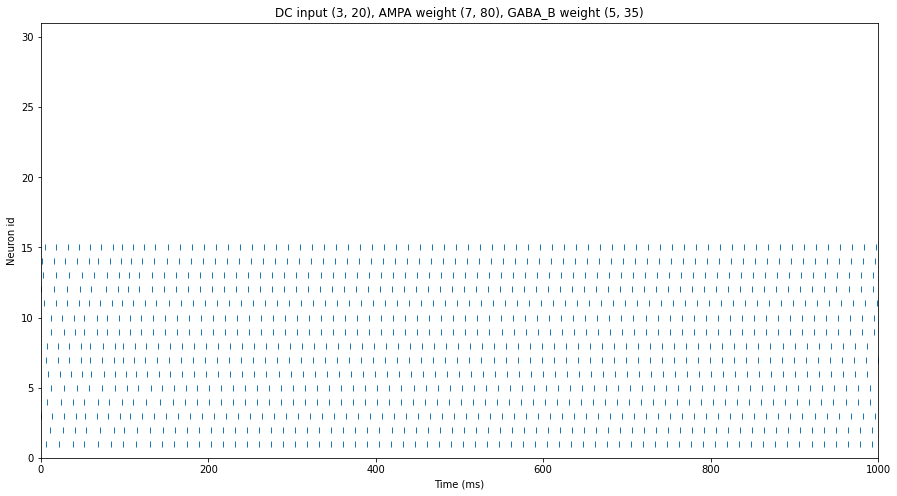

In [104]:
plt.figure(figsize=[15,8])
plt.plot(spikes[:,0]/1000, spikes[:,1],'|')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron id')
plt.ylim([0,31])
plt.xlim([0,1000])
plt.title(f'DC input {dc_input}, AMPA weight {ampa_weight}, GABA_B weight {gaba_b_weight}')

plt.show()

In [ ]:
def spikes_of_neuron_id(neuron_id):
    neuron_spike_times = []
    for spike in spikes:
        if neuron_id == spike.id: 
            neuron_spike_times.append(spike.timestamp)        
    return neuron_spike_times

all_neuron_ISI = []
for neuron_id in all_nids:
    spike_times = spikes_of_neuron_id(neuron_id)
    neuron_ISI = np.diff(spike_times)/1000
    all_neuron_ISI.append(neuron_ISI)


plt.figure(figsize=[15,8])
for i in range(num_neurons):
    r = i+15
    plt.plot(np.arange(len(all_neuron_ISI[i+num_neurons])), all_neuron_ISI[i+num_neurons], label = 'id %s' %r)
plt.legend()
plt.xlabel('Spike number')
plt.ylabel('Inter spike interval (ms)')
plt.show()
k = 24
plt.figure(figsize=[15,8])
plt.plot(all_neuron_ISI[k], label = 'id %s' %k)
plt.legend()
plt.xlabel('Spike number')
plt.ylabel('Inter spike interval (ms)')
plt.show()

In [ ]:
plt.figure(figsize=[15,4])
plt.scatter(np.arange(len(all_neuron_ISI[k])), all_neuron_ISI[k], label = 'id %s' %k)
plt.legend()
plt.xlabel('Spike number')
plt.ylabel('Inter spike interval (ms)')
#plt.xlim([10,25])
#plt.ylim([200,500])
plt.show()

In [ ]:
import time
import cv2
from IPython.display import clear_output

In [ ]:
# poisson_gen.start()
dynapse.start_graph()

for i in range(100):
    spikes = dynapse.sink_node.get_buf()
    spike_ids = np.array([1024*spike.chip_id+256*spike.core_id+spike.neuron_id for spike in spikes])
    print(np.shape(spike_ids))
    spiking_neurons = np.unique(spike_ids)
    print(spiking_neurons)
    rates = np.array([np.count_nonzero(spike_ids == neuron_index) for neuron_index in spiking_neurons])
    print(rates)
    img = np.zeros(1024)
    if len(spikes) > 0:
        img[spiking_neurons] = rates
    plt.imshow(np.reshape(img,(32,32)))
    plt.title(str(i))
    plt.show()
    clear_output(wait=True)

dynapse.stop_graph()
# poisson_gen.stop()